In [1]:
import ssms
import lanfactory 
import os
import numpy as np
from copy import deepcopy
import torch

In [2]:
MODEL = 'angle'
RUN_SIMS = False

In [3]:
# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config['lan'])
# Specify generative model (one from the list of included models mentioned above)
generator_config['dgp_list'] = MODEL
# Specify number of parameter sets to simulate
generator_config['n_parameter_sets'] = 256
# Specify how many samples a simulation run should entail
generator_config['n_samples'] = 2000
# Specify folder in which to save generated data
generator_config['output_folder'] = 'data/lan_mlp/'

# Make model config dict
model_config = ssms.config.model_config[MODEL]

In [4]:
model_config

{'name': 'angle',
 'params': ['v', 'a', 'z', 't', 'theta'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.001, -0.1], [3.0, 3.0, 0.9, 2.0, 1.3]],
 'boundary': <function ssms.basic_simulators.boundary_functions.angle(t=1, theta=1)>,
 'n_params': 5,
 'default_params': [0.0, 1.0, 0.5, 0.001, 0.0],
 'hddm_include': ['z', 'theta'],
 'nchoices': 2}

In [5]:
generator_config['output_folder'] = 'data/lan_mlp/' + generator_config['dgp_list'] + '/' + \
                                    str(generator_config['n_samples']) + '_' + \
                                        str(generator_config['n_training_samples_by_parameter_set']) + '/'

In [6]:
if RUN_SIMS:
    n_datafiles = 20
    for i in range(n_datafiles):
        print('Datafile: ', i)
        my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(generator_config = generator_config,
                                                                              model_config = model_config)
        training_data = my_dataset_generator.generate_data_training_uniform(save = True)

In [7]:
import pickle
my_data = pickle.load(open('data/lan_mlp/angle/2000_1000/training_data_8d617928653811eebb25a0423f3e9be0.pickle' , 'rb'))

In [8]:
my_data['labels']

array([ -1.68907  ,  -1.2301161,  -1.247614 , ..., -66.77497  ,
       -66.77497  , -66.77497  ], dtype=float32)

In [9]:
network_config = lanfactory.config.network_configs.network_config_mlp

print('Network config: ')
print(network_config)

train_config = lanfactory.config.network_configs.train_config_mlp

print('Train config: ')
print(train_config)

Network config: 
{'layer_sizes': [100, 100, 1], 'activations': ['tanh', 'tanh', 'linear'], 'train_output_type': 'logprob'}
Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}


In [10]:
train_config['cpu_batch_size'] = 128
train_config['gpu_batch_size'] = 2048
train_config['n_epochs'] = 20

In [11]:
folder_ = 'data/lan_mlp/' + MODEL + '/2000_1000/'
file_list_ = [folder_ + file_ for file_ in os.listdir(folder_)]

# Training dataset
jax_training_dataset = lanfactory.trainers.DatasetTorch(file_ids = file_list_,
                                                          batch_size = train_config['gpu_batch_size'] if \
                                                                            torch.cuda.is_available() else train_config['cpu_batch_size'],
                                                          label_lower_bound = np.log(1e-10),
                                                          features_key='data',
                                                          label_key='labels',
                                                          out_framework='jax',
                                                          )

jax_training_dataloader = torch.utils.data.DataLoader(jax_training_dataset,
                                                        shuffle = True,
                                                        batch_size = None,
                                                        num_workers = 1,
                                                        pin_memory = True)

# Validation dataset
jax_validation_dataset = lanfactory.trainers.DatasetTorch(file_ids = file_list_,
                                                            batch_size = train_config['gpu_batch_size'] if \
                                                                            torch.cuda.is_available() else train_config['cpu_batch_size'],
                                                            
                                                            label_lower_bound = np.log(1e-10),
                                                            features_key='data',
                                                            label_key='labels',
                                                            out_framework='jax',)

jax_validation_dataloader = torch.utils.data.DataLoader(jax_validation_dataset,
                                                          shuffle = True,
                                                          batch_size = None,
                                                          num_workers = 1,
                                                          pin_memory = True)

In [12]:
cnt = 0 
for xb, yb in jax_training_dataloader:
    print(xb)
    print(yb)
    cnt += 1
    if cnt > 0:
        break

tensor([[ 0.4723,  2.8080,  0.6124,  ...,  1.0561, -0.9777, -1.0000],
        [ 0.4704,  2.5968,  0.4627,  ..., -0.0078,  6.5930,  1.0000],
        [-1.4165,  0.3726,  0.3885,  ...,  0.6151,  1.3899,  1.0000],
        ...,
        [ 2.7298,  0.6473,  0.2409,  ...,  0.4128,  2.2906,  1.0000],
        [-1.0650,  1.1257,  0.3168,  ...,  1.0982,  2.1769, -1.0000],
        [-0.2911,  1.2660,  0.8203,  ...,  0.1788,  5.8098, -1.0000]])
tensor([[-23.0259],
        [ -2.7120],
        [  0.1846],
        ...,
        [ -0.3429],
        [  0.7551],
        [ -7.4625]])


In [13]:
# LOAD NETWORK
jax_net = lanfactory.trainers.MLPJaxFactory(network_config = network_config,
                                            train = True)


In [14]:
jax_trainer = lanfactory.trainers.ModelTrainerJaxMLP(train_config=train_config,
                   model = jax_net,
                   train_dl = jax_training_dataloader,
                   valid_dl = jax_validation_dataloader,
                   pin_memory = True)

In [16]:
train_state = jax_trainer.train_and_evaluate(output_folder = "data/trained_model/jax/",
                               output_file_id = MODEL,
                               run_id = 'test_run_notebook',
                               wandb_on = True,
                               wandb_project_id = 'test_run_notebook',
                               save_data_details = True,
                               verbose = 1,
                               save_all = True)

Found folder:  data
Moving on...
Found folder:  data/trained_model
Moving on...
Did not find folder:  data/trained_model/jax
Creating it...


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: afengler. Use `wandb login --relogin` to force relogin


Epoch: 0 of 20
Training - Step: 0 of 2440 - Loss: 4.814271
Training - Step: 1000 of 2440 - Loss: 0.15132537
Training - Step: 2000 of 2440 - Loss: 0.10933632
Epoch 0/20 time: 4.711242198944092s
Validation - Step: 0 of 2440 - Loss: 0.091268525
Validation - Step: 1000 of 2440 - Loss: 0.09796025
Validation - Step: 2000 of 2440 - Loss: 0.08871734
Epoch 0/20 time: 3.4193437099456787s
Epoch: 0 / 20, test_loss: 0.09923399984836578
Epoch: 1 of 20
Training - Step: 0 of 2440 - Loss: 0.12810232
Training - Step: 1000 of 2440 - Loss: 0.06930448
Training - Step: 2000 of 2440 - Loss: 0.06441811
Epoch 1/20 time: 3.4112942218780518s
Validation - Step: 0 of 2440 - Loss: 0.05547302
Validation - Step: 1000 of 2440 - Loss: 0.073870346
Validation - Step: 2000 of 2440 - Loss: 0.06404884
Epoch 1/20 time: 3.155444622039795s
Epoch: 1 / 20, test_loss: 0.0665491446852684
Epoch: 2 of 20
Training - Step: 0 of 2440 - Loss: 0.07638124
Training - Step: 1000 of 2440 - Loss: 0.064256534
Training - Step: 2000 of 2440 - Lo

In [16]:
# Loaded Net
jax_infer = lanfactory.trainers.MLPJaxFactory(network_config = 'data/torch_models/angle/angle_torch_network_config.pickle',
                                              train = False)

In [17]:
forward_pass, forward_pass_jitted = jax_infer.make_forward_partial(seed = 42,
                                            input_dim = model_config['n_params'] + 2,
                                            state = 'data/trained_model/jax/test_run_notebook_lan_angle__train_state.jax',
                                            add_jitted = True,
                                            )

In [24]:
import jax.numpy as jnp
# Test parameters:
v, a, z, t, theta = 0.5, 1.5, 0.5, 0.3, 0.3

# Comparison simulator run
sim_out = ssms.basic_simulators.simulator.simulator(model = MODEL, 
                                          theta = [v,a,z,t,theta],
                                          n_samples = 50000)

# Make input matric
input_mat = jnp.zeros((2000, 7))
input_mat = input_mat.at[:, 0].set(jnp.ones(2000) * v)
input_mat = input_mat.at[:, 1].set(jnp.ones(2000) * a)
input_mat = input_mat.at[:, 2].set(jnp.ones(2000) * z)
input_mat = input_mat.at[:, 3].set(jnp.ones(2000) * t)
input_mat = input_mat.at[:, 4].set(jnp.ones(2000) * theta)
input_mat = input_mat.at[:, 5].set(jnp.array(np.concatenate([np.linspace(5, 0, 1000).astype(np.float32),
                                              np.linspace(0, 5, 1000).astype(np.float32)])))
input_mat = input_mat.at[:, 6].set(jnp.array(np.concatenate([np.repeat(-1., 1000), np.repeat(1., 1000)]).astype(np.float32)))

net_out = forward_pass_jitted(input_mat)

In [31]:
net_out

Array([[-10.9201765],
       [-10.892712 ],
       [-10.864927 ],
       ...,
       [-10.891985 ],
       [-10.910214 ],
       [-10.928265 ]], dtype=float32)

(array([4.69769437e-04, 8.22096514e-04, 1.64419303e-03, 5.05002144e-03,
        1.11570241e-02, 1.56198338e-02, 2.24314906e-02, 3.03001287e-02,
        4.07524986e-02, 5.19095227e-02, 6.55328364e-02, 8.18573243e-02,
        8.94910777e-02, 1.05345796e-01, 1.12509780e-01, 1.30478461e-01,
        1.36233137e-01, 1.41165716e-01, 1.48916911e-01, 1.36468021e-01,
        9.31317908e-02, 1.98477587e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 7.04654155e-04, 1.05110911e-01,
        3.65832949e-01, 5.13927764e-01, 5.39999967e-01, 5.00891662e-01,
        4.50978659e-01, 3.92140037e-01, 3.35297935e-01, 2.85502375e-01,
        2.31478890e-01, 1.86968236e-01, 1.51265759e-01, 1.18734225e-01,
        9.13701554e-02, 6.34188739e-02, 4.07524986e-02, 2.65419732e-02,
        1.70291421e-02, 7.98608042e-03, 3.40582841e-03, 1.29186595e-03,
        2.34884718e-04, 1.17442359e-04]),
 array([-4.17047739, -4.00018108, -3.82988478, -3.65958847, -3.48929216,
        -3.31899586, 

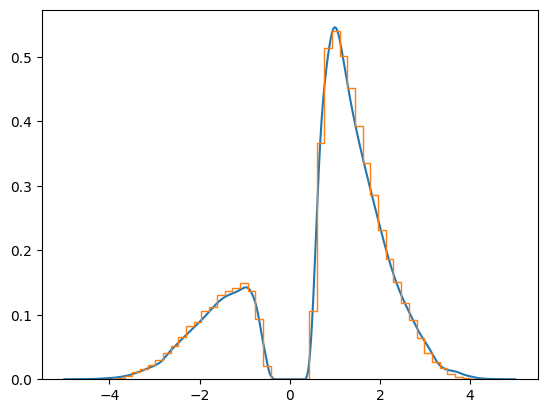

In [32]:
from matplotlib import pyplot as plt
plt.plot(np.linspace(-5, 5, 2000).astype(np.float32), 
         np.exp(net_out))

plt.hist(sim_out['rts'] * sim_out['choices'], bins = 50, histtype = 'step', fill = None, density = True)